In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
# import seaborn as sns 
from pathlib import Path
import xarray as xr

# from osgeo import gdal
# import subprocess
import requests 
from pprint import pprint 

import pyproj 

%matplotlib notebook

In [2]:
'''
TO DO
 - missing recession curve value for cell --> (1) no recessions observed in timeseries --> all nan values;
                                              (2) recession periods too short for threshold values 
 - try to find out missing values relations
 
CONCLUSIONS / DONE:
 - gauge 6125080, has only 2 observations in period 1991-2020, not enough data 
 - gauge 6139720 has only 14 observations - also not enough data (probably) 
 
 - idea: start learning features with smaller dataset - without missing values (drop set) 
       --> then expand with hnew features?
       
 - fill gauge elevation data with EU-DEM and Aster30
''';

In [3]:
training_dir = Path(r"C:\Users\mvand\Documents\Master EE\Year 4\Thesis\data\training_data_S1") 

gauge_meta = training_dir / "V1_grdc_efas_selection-cartesius-snapped-1.csv"


In [4]:
# STEP 1 - merge all CSV signatures files into 1 csv file  / load signatuer file 

fn_signatures =  training_dir / "signatures_nc_V1_output" / "S1_merged_signatures_v2.csv" 

load_file = True

###################################################################
###################################################################
if not load_file:
    
    def merge_signature_csv(src_dir, ix_col='ID'):
        files = [file for file in src_dir.glob('*.csv')]
        df = pd.concat(map(pd.read_csv, files))
        df = df.set_index(ix_col)
        return df 
    
    csv_signature_dir_1 = training_dir / "signatures_nc_V1_output" / "csv_signatures"
    csv_signature_dir_2 = training_dir / "signatures_nc_V1_output" / "csv_signatures_p2"  
    
    df_1 = merge_signature_csv(csv_signature_dir_1)
    df_2 = merge_signature_csv(csv_signature_dir_2)

    ## merge df_1 and df_2 based on indices 
    cols_to_merge = np.setdiff1d(df_2.columns, df_1.columns )  
    df_merge = df_2[cols_to_merge]
    df_signatures = pd.concat([df_1, df_merge], axis=1) 

    ## save file 
    df_signatures.to_csv(fn_signatures) 

###################################################################
###################################################################
if load_file:
    ## or load file 
    df_signatures = pd.read_csv(fn_signatures, index_col=0)
    
###################################################################    
###################################################################

## add column with belonging gauge ID 
tag_gauge = df_signatures.index.str.split('_').str[0]
df_signatures['tag'] = tag_gauge

df_signatures 

,Nm-all,Ns-all,N-gof-all,Lm-all,Ls-all,L-gof-all,Gu-all,Ga-all,Gev-gof-all,Gk-all,...,lf-t-seasonal_1,lf-t-seasonal_2,lf-t-seasonal_3,lf-t-seasonal_4,pks-all,pks-seasonal_1,pks-seasonal_2,pks-seasonal_3,pks-seasonal_4,tag
ID,,,,,,,,,,,,,,,,,,,,,
6119010_11,102.035362,106.090645,0.0,4.221500,0.863208,0.0,54.306767,0.012089,0.0,0.925012,...,4.481481,1.045455,0.000000,0.000000,666.803894,550.015259,479.626465,212.843933,673.393555,6119010
6119010_12,100.917046,105.168777,0.0,4.209119,0.864435,0.0,53.603184,0.012195,0.0,0.920779,...,4.518519,1.086957,0.000000,0.000000,654.762268,549.104004,470.134583,212.791443,666.401978,6119010
6119010_13,0.544169,0.542255,0.0,-1.002645,0.867551,0.0,0.300217,2.365214,0.0,1.007072,...,6.000000,0.000000,0.000000,8.636364,3.131104,2.947998,2.192993,0.960388,3.788452,6119010
6119010_14,162.321777,138.910507,0.0,4.760090,0.835850,0.0,99.828016,0.009233,0.0,1.365474,...,7.227273,2.880000,4.181818,7.960000,723.082581,657.824402,661.195068,604.262695,815.905151,6119010
6119010_15,17.163115,16.641987,0.0,2.442999,0.888787,0.0,9.676133,0.077067,0.0,1.063609,...,6.083333,0.000000,0.000000,9.846154,98.092957,88.489990,74.034424,37.886658,124.954529,6119010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6983350_96,522.018127,325.349060,0.0,6.080506,0.592225,0.0,375.648448,0.003942,0.0,2.574376,...,0.000000,0.000000,0.000000,0.000000,1890.435181,574.974670,1660.376587,1322.813416,659.456177,6983350
6983350_97,1.769354,1.644365,0.0,0.271318,0.743112,0.0,1.029579,0.779967,0.0,1.157798,...,6.181818,0.000000,0.000000,0.222222,10.525513,11.605530,8.256226,8.186340,9.359741,6983350
6983350_98,6.406629,5.884712,0.0,1.530997,0.797030,0.0,3.759185,0.217946,0.0,1.185247,...,4.800000,0.000000,0.888889,2.666667,33.151855,41.973267,34.476318,29.242249,29.821472,6983350


In [5]:
# STEP 2 - load gauge metadata 
df_gauge_meta = pd.read_csv(gauge_meta, index_col=0) 

df_gauge_meta['p_missing'] = ( df_gauge_meta['n_nan_EFAS_period'] / df_gauge_meta['n_obs_EFAS_period'])*100

df_gauge_meta

,Lisflood_X,Lisflood_Y,gauge_lat,gauge_lon,upArea,start_year,start_month,end_year,end_month,proj_X,proj_Y,x_snap,y_snap,d_X,d_Y,d_X_cell,d_Y_cell,n_obs_EFAS_period,n_nan_EFAS_period,p_missing
gauge_ID,,,,,,,,,,,,,,,,,,,,
6119010,3442500.0,2332500.0,43.507821,-0.853697,2575.000,1923.0,7.0,2012.0,6.0,3.444512e+06,2.330120e+06,3442500.0,2332500.0,0.0,0.0,0.0,0.0,7839.0,35.0,0.446486
6119100,3512500.0,2317500.0,43.480000,0.000000,84.300,1968.0,10.0,1991.0,12.0,3.512582e+06,2.317464e+06,3512500.0,2317500.0,0.0,0.0,0.0,0.0,365.0,0.0,0.000000
6122141,3812500.0,2962500.0,49.559185,2.993209,4290.000,1955.0,1.0,2012.0,6.0,3.814856e+06,2.962640e+06,3812500.0,2962500.0,0.0,0.0,0.0,0.0,7840.0,2.0,0.025510
6140600,4742500.0,3007500.0,50.036700,15.906700,625.413,1910.0,11.0,2018.0,12.0,4.743683e+06,3.008617e+06,4742500.0,3007500.0,0.0,0.0,0.0,0.0,10227.0,0.0,0.000000
6122350,3857500.0,2842500.0,48.500000,3.700000,104.000,1962.0,3.0,1991.0,12.0,3.855884e+06,2.840607e+06,3857500.0,2842500.0,0.0,0.0,0.0,0.0,365.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6854102,5057500.0,4322500.0,61.308421,23.749779,8641.000,1962.0,1.0,2017.0,12.0,5.054811e+06,4.317055e+06,5052500.0,4317500.0,5000.0,5000.0,1.0,1.0,9862.0,0.0,0.000000
6854205,5162500.0,4367500.0,61.566581,26.044766,1421.000,1910.0,1.0,2014.0,12.0,5.168086e+06,4.370882e+06,5167500.0,4372500.0,-5000.0,-5000.0,-1.0,-1.0,8766.0,0.0,0.000000
6855410,5362500.0,4567500.0,62.784697,30.764044,4183.000,1977.0,1.0,2009.0,12.0,5.367560e+06,4.565461e+06,5367500.0,4567500.0,-5000.0,0.0,-1.0,0.0,6940.0,0.0,0.000000


In [6]:
## STEP 3 - categorize columns 
## except streamflow signatures - lists below specify other types 
## of information in dataframe 
cols_metadata = ['n_buffer', 'target', 'tag']
cols_location_info = ['x', 'y', 'lat', 'lon'] 
non_feature_cols = ['tag', 'n_buffer']

tareget_col = ['target']

all_columns = df_signatures.columns.values 

                     ## normal distribution parameters
feature_categories = ['Nm', 'Ns', 'N-gof',
                     ## log-normal distribution parameters
                      'Lm', 'Ls', 'L-gof',
                     ## gumbel distribution parameters
                      'Gu','Ga', 'Gev-gof',
                     ## gamma distribution parameters
                      'Gk', 'Gt', 'G-gof',
                     ## poisson distribution parameters
                      'Pl', 'P-gof',
                     ## lagged auto/cross correlation parameters
                      'alag-1', 'clag-0', 'clag-1',
                     ## flow duration curve percentiles
                      'fdcQ-1', 'fdcQ-2', 'fdcQ-5', 'fdcQ-10',
                     ## flow duration curve percentiles
                      'fdcQ-50', 'fdcQ-90', 'fdcQ-95', 'fdcQ-99',
                     ## flod duration curve indices: slope & low flow ratio
                      'fdcS', 'lf', 
                     ## baseflow index, declininb limb density, rising limb density
                      'bfi', 'dld', 'rld',  
                     ## richard-baker flashines, recession curve slope and intercept
                      'rbf', 'b_rc', 'a_rc',
                      ## location descriptors 
                      'upArea', 'elevation',
                      ## concavity index, high flow volume, low flow volume
                      'ci', 'fhv', 'flv',
                      ## high/low flow frequency and duration
                      'hf-f', 'hf-t', 'lf-f', 'lf-t',
                      ## peak distribution
                      'pks' 
                     ]

In [7]:
## STEP 4 - data cleanup 

## strategy:
## 1 - explore nan values 
## 2 - where possible, fill missing values 
## 3 - cleanup remaining missing values  

In [8]:
## 1 - explore nan values 
n_fields = df_signatures.shape[0] * df_signatures.shape[1]
print( 'Total % missing data: {:.2f}%'.format( (df_signatures.isnull().sum().sum() / n_fields)*100)  )

df_nan = df_signatures.isnull().sum().sort_values()
df_nan

Total % missing data: 3.56%


tag                   0
n_buffer              0
lat                   0
lon                   0
x                   595
                   ... 
lf-f-seasonal_4    3421
lf-t-seasonal_4    3421
hf-t-seasonal_4    3421
hf-f-seasonal_4    3421
rbf-seasonal_4     3421
Length: 214, dtype: int64

In [9]:
### 2 - HANDLING MISSING VALUES 

## missing values for x and y can be solved by projecting lat/lon (epsg:4326) to EFAs grid (epsg:3035) 

def reproject_coordinates(src_coords, src_epsg, dst_epsg=int(4326)):
    
    '''
    Function that transforms coordinates - assumes input is a matrix 
    of 2 columns and n rows, with first column containing x/lon coordinates,
    and second column with y/lat coordinates - returns a 2D array with first 
    '''

    if type(src_coords) != np.ndarray or  len(src_coords.shape) < 2:
        src_coords = np.array([src_coords])
         
    ## check input 
    assert src_coords.shape[1] >= 2, '[ERROR] coordinates are not pairwise'
    assert type(src_epsg) == int, '[ERROR] source epsg code (src_epsg) is not an integer'
    assert type(src_epsg) == int, '[ERROR] destination epsg code (dst_epsg) is not an integer' 
    
    
    ## extract x and y coordinates as vectors 
    src_x = src_coords[:,0]
    src_y = src_coords[:,1]
    
    ## define transformer 
    transformer = pyproj.Transformer.from_crs('epsg:{}'.format(int(src_epsg)),
                                             'epsg:{}'.format(dst_epsg))
    
    ## transform vectors & return 
    dst_y, dst_x = transformer.transform(src_y, src_x)
    return np.array([dst_x, dst_y]).transpose() 


## find rows with missing x or y coordinates 
missing_coords = df_signatures[ (df_signatures['x'].isnull()) | (df_signatures['y'].isnull()) ]

reproj_coords = reproject_coordinates( missing_coords[['lon', 'lat']].values, 4326, 3035 )

df_signatures.loc[ missing_coords.index, 'x' ] = reproj_coords[:,0] 
df_signatures.loc[ missing_coords.index, 'y' ] = reproj_coords[:,1]

print('After filling in missing xy coordinates:')
print( '\t% missing data: {:.2f}%'.format( (df_signatures.isnull().sum().sum() / n_fields)*100)  )

After filling in missing xy coordinates:
	% missing data: 3.55%


In [10]:
### 2 - HANDLING MISSING VALUES  

## missing target values are in gauge rows - these values can be either set to  0 
##      note that they will be dropped after similarity calculations 

df_signatures['target'] = df_signatures['target'].fillna(0) 

print('After filling in missing target values in gauges:')
print( '\t% missing data: {:.2f}%'.format( (df_signatures.isnull().sum().sum() / n_fields)*100)  )

After filling in missing target values in gauges:
	% missing data: 3.55%


In [11]:
### 2 - HANDLING MISSING VALUES 

## check how many rows have all NaN values 
df_nan_rows = df_signatures.isnull().sum(axis=1).sort_values() 

## if all values in a row have nan 
## it can be assumed that no data is available (no land cell) 
nan_sum = df_nan_rows.max() 
nan_mask = df_nan_rows.loc[ df_nan_rows >= nan_sum ] 


## check if targets here 
nan_target_vals = df_signatures.loc[nan_mask.index]['target'].unique() 
print('Target value in nan rows: ', 1. in nan_target_vals) 

if not 1. in nan_target_vals:
    print('So all rows with over {} nan values can be dropped'.format(nan_sum))  
    
    df_signatures = df_signatures.drop(index = nan_mask.index ).copy() 
    
    print('\t remaining percentage missing data: {:.2f}%'.format( (df_signatures.isnull().sum().sum() / n_fields)*100) ) 

207 1556
Target value in nan rows:  False
So all rows with over 207 nan values can be dropped
	 remaining percentage missing data: 0.46%


In [12]:
### 2 - HANDLING MISSING VALUES

## check how many rows remain with 1 or more missing values 
df_nan_rows = df_signatures.isnull().sum(axis=1).sort_values() 
nan_mask_rows = df_nan_rows.loc[ df_nan_rows > 0] 
print("{:.2f} % of rows have one or more missing data points".format( (len(nan_mask_rows)/len(df_signatures)*100)))

df_nan_cols = df_signatures.isnull().sum().sort_values()
nan_mask_cols = df_nan_cols.loc[ df_nan_cols > 0] 
print("{} / {} columns have one or more missing rows with missing data".format( len(nan_mask_cols), len(df_nan_cols) ) )

print('\nNow check per source type (gauge or cell) ')

5.79 % of rows have one or more missing data points
137 / 214 columns have one or more missing rows with missing data

Now check per source type (gauge or cell) 


In [13]:
### 2 - HANDLING MISSING VALUES

print('Analyse missing data for GAUGE data')

gauge_rows = [ix for ix in df_signatures.index.values if 'gauge' in ix] 
df_gauge = df_signatures.loc[gauge_rows] 

df_gauge_nan_rows = df_gauge.isnull().sum(axis=1).sort_values()
gauge_nan_mask_rows = df_gauge_nan_rows.loc[df_gauge_nan_rows > 0].index

df_gauge_nan_cols = df_gauge.isnull().sum(axis=0).sort_values()
gauge_nan_mask_cols = df_gauge_nan_cols.loc[df_gauge_nan_cols >0] 

print("In {}/{} rows, or {}/{} columns, values are missing".format( len(gauge_nan_mask_rows), len(df_gauge),
                                                                   len(gauge_nan_mask_cols), df_gauge.shape[1]) )

Analyse missing data for GAUGE data
In 595/595 rows, or 133/214 columns, values are missing


In [14]:
### 2 - HANDLING MISSING VALUES

print('Analyse missing data for CELL data')
cell_rows = [ix for ix in df_signatures.index.values if not 'gauge' in ix]

df_cell = df_signatures.loc[cell_rows] 

df_cell_nan_rows = df_cell.isnull().sum(axis=1).sort_values()
cell_nan_mask_rows = df_cell.loc[df_cell_nan_rows > 0].index 

df_cell_nan_cols = df_cell.isnull().sum(axis=0).sort_values()
cell_nan_mask_cols = df_cell_nan_cols.loc[df_cell_nan_cols>0] 

print("In {}/{} rows, or {}/{} columns, values are missing".format( len(cell_nan_mask_rows), len(df_cell),
                                                                    len(cell_nan_mask_cols), df_cell.shape[1]) )

Analyse missing data for CELL data
In 2141/46639 rows, or 132/214 columns, values are missing


In [15]:
### 2 - HANDLING MISSING VALUES

print('Find overlapping and non-overlapping missing values')

both_missing = np.intersect1d(gauge_nan_mask_cols.index.values, cell_nan_mask_cols.index.values)

gauge_missing = np.setdiff1d(gauge_nan_mask_cols.index.values, cell_nan_mask_cols.index.values)
cell_missing = np.setdiff1d(cell_nan_mask_cols.index.values, gauge_nan_mask_cols.index.values)
print(both_missing)

print('\nOnly missing for gauge data:')
print(gauge_missing)

print('\nOnly missing for cell data:')
print(cell_missing)

Find overlapping and non-overlapping missing values
['G-gof-seasonal_2' 'G-gof-seasonal_3' 'G-gof-seasonal_4' 'Ga-seasonal_2'
 'Ga-seasonal_3' 'Ga-seasonal_4' 'Gev-gof-seasonal_2' 'Gev-gof-seasonal_3'
 'Gev-gof-seasonal_4' 'Gk-seasonal_2' 'Gk-seasonal_3' 'Gk-seasonal_4'
 'Gt-seasonal_2' 'Gt-seasonal_3' 'Gt-seasonal_4' 'Gu-seasonal_2'
 'Gu-seasonal_3' 'Gu-seasonal_4' 'L-gof-seasonal_2' 'L-gof-seasonal_3'
 'L-gof-seasonal_4' 'Lm-seasonal_2' 'Lm-seasonal_3' 'Lm-seasonal_4'
 'Ls-seasonal_2' 'Ls-seasonal_3' 'Ls-seasonal_4' 'N-gof-seasonal_2'
 'N-gof-seasonal_3' 'N-gof-seasonal_4' 'Nm-seasonal_2' 'Nm-seasonal_3'
 'Nm-seasonal_4' 'Ns-seasonal_2' 'Ns-seasonal_3' 'Ns-seasonal_4'
 'P-gof-seasonal_2' 'P-gof-seasonal_3' 'P-gof-seasonal_4' 'Pl-seasonal_2'
 'Pl-seasonal_3' 'Pl-seasonal_4' 'a_rc-all' 'a_rc-seasonal_1'
 'a_rc-seasonal_2' 'a_rc-seasonal_3' 'a_rc-seasonal_4' 'alag-1-seasonal_2'
 'alag-1-seasonal_3' 'alag-1-seasonal_4' 'b_rc-all' 'b_rc-seasonal_1'
 'b_rc-seasonal_2' 'b_rc-seasonal_3' 'b_

In [16]:
### 2 - HANDLING MISSING VALUES

print('All gauge-only missing columns are cross-correlation columns - which is the cross correlation of simulations with observations')
print('\tclag values can be filled with 1 as they are "0-lag autocorrelation"')
print('\tbut for calculation of similarity values, they should not be considerd')

c_lag_cols = [col for col in df_signatures.columns if 'clag' in col] 
df_signatures.loc[gauge_rows, c_lag_cols] = 1

gauge_missing = np.setdiff1d(gauge_missing, c_lag_cols)
print('\nRemaining columns with missing values - gauge only: ', gauge_missing)
print('Of {} gauges, data is missing for {} gauges'.format(len(df_gauge), df_gauge[gauge_missing].isnull().sum().sum() ))

All gauge-only missing columns are cross-correlation columns - which is the cross correlation of simulations with observations
	clag values can be filled with 1 as they are "0-lag autocorrelation"
	but for calculation of similarity values, they should not be considerd

Remaining columns with missing values - gauge only:  ['elevation']
Of 595 gauges, data is missing for 85 gauges


In [17]:
### 2 - HANDLING MISSING VALUES

## fill missing elevation data 
## using EU-DEM (25m) and ASTER (30 m) 

## results of RMSE test (with 100 samples)
## EU-DEM RMSE = 76.79179258408521
## ASTER RMSE  = 78.22125586795445
## first choice for EU-DEM since (1) higher resolution

def open_topo_request(df, dataset = 'eudem25m'):
    
    ## for more information: https://www.opentopodata.org/
    
    ## max 100 locations per request
    ## max 1 request per second
    ## max 1000 calls per day 
    
    collect_coords = []

    if len(df) > 100:
        print('Max 100 locations - take sample')
        df = df.sample(100)
    
    for index in df.index:
        lat, lon = df.loc[index, ['lat', 'lon']].values  
        string_coords = '{},{}'.format(lat,lon)
        collect_coords.append(string_coords) 
    
    base_url = "https://api.opentopodata.org/v1/{}?locations={}".format( dataset,  '|'.join(collect_coords) )
    response = requests.get(base_url)    
    content = response.json()
    
    for i, index in enumerate(df.index):
        val = content['results'][i]["elevation"]
        df.loc[index, 'fill_dem'] = val
    return df

def test_and_fill_with_api(df, threshold=100., check_rmse=True):
    
    df_vals = df[['x', 'y', 'lat', 'lon', 'elevation']].copy() 
    
    do_fill = True 
    
    if check_rmse:
        
        ## first test error of DEM with gauge values 
        df_check = df_vals.loc[ df_vals['elevation'].notna() ].sample(100).copy()
        
        ## calculate rmse between gauge data and dem dataset 
        df_check = open_topo_request(df_check)
#         df_check = open_topo_request(df_check, dataset = 'aster30m')

        ## drop nan values and continue RMSE calculation
        df_check = df_check.dropna(subset=['fill_dem']).copy()

        ## calculate RMSE 
        df_check['abs_diff'] = ((df_check['fill_dem']-df_check['elevation'])**2) 

        rmse = (df_check['abs_diff'].sum()/len(df_check))**0.5
        print('\nRMSE: ', rmse )   
        
        if rmse > threshold:
            print('RMSE () larger than threshold () - use other dataset')
            do_fill = False
            return df_vals 
    
    if do_fill:
        
        print('Fill values with EU-DEM dataset')
        
        df_nan = df_vals.loc[ df_vals['elevation'].isnull() ].copy() 
        
        df_nan = open_topo_request(df_nan) 
                
        df_vals['dem_filled'] = 0
        df_vals.loc[ df_nan.index, 'dem_filled'] = 1
        df_vals.loc[ df_nan.index, 'elevation'] = df_nan['fill_dem'] 
        
        if df_vals['elevation'].isnull().sum() > 0:
            print('Missing data remains\nTry filling remaining values with global dataset')
            df_nan = df_vals.loc[ df_vals['elevation'].isnull() ].copy() 
            
            ## use aster30 for highest global coverage
            df_nan = open_topo_request(df_nan, dataset = 'aster30m')       
            df_vals.loc[ df_nan.index, 'elevation'] = df_nan['fill_dem'] 
    
        print('Remaining missing values: ', df_vals['elevation'].isnull().sum())
        return df_vals 

df_gauge_filled = test_and_fill_with_api(df_gauge, check_rmse=False) 

## add to dataset 
fill_elevation =  df_gauge_filled[df_gauge_filled['dem_filled'] == 1.].index

## add column to indicate fille
df_signatures['dem_flag'] = 0
df_signatures.loc[ fill_elevation, 'elevation' ] = df_gauge_filled.loc[fill_elevation, 'elevation'] 
df_signatures.loc[ fill_elevation, 'dem_flag' ] = 1.

Fill values with EU-DEM dataset
Missing data remains
Try filling remaining values with global dataset
Remaining missing values:  0


In [18]:
### 2 - HANDLING MISSING VALUES 

print('Columns contain missing values for cell data only: \n', cell_missing) 

missing_upArea = df_cell.loc[ df_cell['upArea'].isnull()]

print('\nCheck upArea again with static upArea file') 
fn_upA = Path(r"C:\Users\mvand\Documents\Master EE\Year 4\Thesis\data\dev\EFAS_upArea4.0.nc")
ds = xr.open_dataset(fn_upA)

for ix in missing_upArea.index:
    search_X, search_Y = df_cell.loc[ix, ['x', 'y']].values
    
    ds_search = ds.sel( {'x': search_X,
                         'y': search_Y},
                         method = 'nearest') 
    
    df_signatures.loc[ix, 'upArea'] = ds_search.ec_upArea.values 
    
ds = None     

print('Remaining missing values for upArea: ', df_signatures.loc[ df_cell['upArea'].isnull().index]['upArea'].isnull().sum())

print('\nFor other columns, number of missing values are: ')

for col in cell_missing:
    if not 'upArea' in col:
        print('\tColumn "{}" has {} missing values'.format(col,
                                                        df_cell[col].isnull().sum()) )

Columns contain missing values for cell data only: 
 ['hf-t-seasonal_1' 'lf-t-all' 'rld-seasonal_1' 'upArea']

Check upArea again with static upArea file
Remaining missing values for upArea:  0

For other columns, number of missing values are: 
	Column "hf-t-seasonal_1" has 1 missing values
	Column "lf-t-all" has 1 missing values
	Column "rld-seasonal_1" has 1 missing values


In [19]:
### 2 - HANDLING MISSING VALUES  

print('Missing values remaining: {:.2f} %'.format( (df_signatures.isnull().sum().sum() / n_fields)*100)  )

missing_columns = df_signatures.columns[ df_signatures.isnull().any(axis=0) ]
missing_rows = df_signatures.loc[ df_signatures.isnull().any(axis=1) ].index 

print('Total number of rows with missing data: {:.2f} % or {}/{} rows'.format( (len(missing_rows)/len(df_signatures))*100, 
                                                    len(missing_rows),
                                                    len(df_signatures)) ) 

## of missing cell rows 
missing_cell_rows = [row for row in missing_rows if not 'gauge' in row]
df_missing_cells = df_signatures.loc[missing_cell_rows]

## missing gauge rows 
missing_gauge_rows = [row for row in missing_rows if 'gauge' in row]
df_missing_gauge = df_signatures.loc[missing_gauge_rows] 

n_missing_total = df_signatures.isnull().sum().sum() 
n_missing_cells = df_missing_cells.isnull().sum().sum()
n_missing_gauge = df_missing_gauge.isnull().sum().sum()

print('\n{:.2f} % ({}) of missing data attributed to missing values in cell data'.format( (n_missing_cells/n_missing_total)*100,
                                                                                         n_missing_cells) )
print('{:.2f} % ({}) of missing data from gauge data'.format( (n_missing_gauge/n_missing_total)*100 ,
                                                             n_missing_gauge) )

## first priority is deadling with remaining missing gauge data 
## one option is to leave all columns with missing gauge data out 
# missing_columns_gauge = df_signatures.columns[ df_signatures.loc[gauge_rows].isnull().any(axis=0) ]
# missing_gauge_vals = df_signatures.loc[gauge_rows, missing_columns_gauge].isnull().sum(axis=1) 
# missing_gauge_df = df_signatures.loc[ missing_gauge_vals[missing_gauge_vals > 0].index]

Missing values remaining: 0.40 %
Total number of rows with missing data: 4.34 % or 2052/47234 rows

98.46 % (41484) of missing data attributed to missing values in cell data
1.54 % (647) of missing data from gauge data


In [20]:
### 3 - CLEANUP 

## STRATEGIES:
## 1 - discard all columns with missing values --> most samples preserved 
## 2 - discard all buffers with missing vvalues --> samples lost, but features preserved 

## TO DO ?
## 3 - try to fill in low percentages of missing values by averiging with neighbouring data 

In [21]:
### 3 - CLEANUP - strategy 1 
### discard all columns with missing values 

df_cleanup_1 = df_signatures.copy() 

## find all columns with missing values 
missing_columns = df_cleanup_1.columns[ df_cleanup_1.isnull().any(axis=0) ]
## drop columns 
df_cleanup_1 = df_cleanup_1.drop(columns = missing_columns) 


print('Number of columns with missing values: {} / {}'.format(len(missing_columns), df_signatures.shape[1])) 
print('Percentage of columns: {:.2f} %'.format( (len(missing_columns)/df_signatures.shape[1])*100)) 
print('After dropping columns: {} missing values remaining'.format(df_cleanup_1.isnull().sum().sum()))

# fn_cleanup_1 = training_dir / "signatures_nc_V1_output" / "S1_merged_signatures_v2-cleanup-1.csv" 
# df_cleanup_1.to_csv(fn_cleanup_1)

cleanup_1_cols = df_cleanup_1.columns.values
print('\nRemaining feature columns:\n', cleanup_1_cols) 

all_dropped = [col for col in missing_columns if 'all' in col]
print('\nOf total timeseries, the following features have been dropped:\n',all_dropped)

print('\n{} features and {} samples remaining'.format(df_cleanup_1.shape[1], df_cleanup_1.shape[0]))

df_cleanup_1 

Number of columns with missing values: 131 / 215
Percentage of columns: 60.93 %
After dropping columns: 0 missing values remaining

Remaining feature columns:
 ['Nm-all' 'Ns-all' 'N-gof-all' 'Lm-all' 'Ls-all' 'L-gof-all' 'Gu-all'
 'Ga-all' 'Gev-gof-all' 'Gk-all' 'Gt-all' 'G-gof-all' 'Pl-all' 'P-gof-all'
 'alag-1-all' 'clag-0-all' 'clag-1-all' 'fdcQ-1-all' 'fdcQ-2-all'
 'fdcQ-5-all' 'fdcQ-10-all' 'fdcQ-50-all' 'fdcQ-90-all' 'fdcQ-95-all'
 'fdcQ-99-all' 'fdcS-all' 'lf-all' 'bfi-all' 'dld-all' 'rld-all' 'rbf-all'
 'Nm-seasonal_1' 'Ns-seasonal_1' 'N-gof-seasonal_1' 'Lm-seasonal_1'
 'Ls-seasonal_1' 'L-gof-seasonal_1' 'Gu-seasonal_1' 'Ga-seasonal_1'
 'Gev-gof-seasonal_1' 'Gk-seasonal_1' 'Gt-seasonal_1' 'G-gof-seasonal_1'
 'Pl-seasonal_1' 'P-gof-seasonal_1' 'alag-1-seasonal_1'
 'clag-0-seasonal_1' 'clag-1-seasonal_1' 'fdcQ-1-seasonal_1'
 'fdcQ-2-seasonal_1' 'fdcQ-5-seasonal_1' 'fdcQ-10-seasonal_1'
 'fdcQ-50-seasonal_1' 'fdcQ-90-seasonal_1' 'fdcQ-95-seasonal_1'
 'fdcQ-99-seasonal_1' 'fdcS-seas

,Nm-all,Ns-all,N-gof-all,Lm-all,Ls-all,L-gof-all,Gu-all,Ga-all,Gev-gof-all,Gk-all,...,flv-seasonal_1,hf-f-all,hf-f-seasonal_1,hf-t-all,lf-f-all,lf-f-seasonal_1,lf-t-seasonal_1,pks-all,tag,dem_flag
ID,,,,,,,,,,,,,,,,,,,,,
6119010_11,102.035362,106.090645,0.0,4.221500,0.863208,0.0,54.306767,0.012089,0.0,0.925012,...,164.721008,0.590909,0.0,2.954545,0.363636,0.636364,4.481481,666.803894,6119010,0
6119010_12,100.917046,105.168777,0.0,4.209119,0.864435,0.0,53.603184,0.012195,0.0,0.920779,...,163.700439,0.590909,0.0,3.090909,0.363636,0.636364,4.518519,654.762268,6119010,0
6119010_13,0.544169,0.542255,0.0,-1.002645,0.867551,0.0,0.300217,2.365214,0.0,1.007072,...,266.693390,0.409091,0.0,1.727273,0.409091,0.636364,6.000000,3.131104,6119010,0
6119010_14,162.321777,138.910507,0.0,4.760090,0.835850,0.0,99.828016,0.009233,0.0,1.365474,...,317.679565,0.045455,0.0,0.136364,1.000000,0.545455,7.227273,723.082581,6119010,0
6119010_15,17.163115,16.641987,0.0,2.442999,0.888787,0.0,9.676133,0.077067,0.0,1.063609,...,248.398575,0.136364,0.0,0.363636,0.454545,0.500000,6.083333,98.092957,6119010,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6983350_96,522.018127,325.349060,0.0,6.080506,0.592225,0.0,375.648448,0.003942,0.0,2.574376,...,60.206692,0.000000,0.0,0.000000,0.111111,0.000000,0.000000,1890.435181,6983350,0
6983350_97,1.769354,1.644365,0.0,0.271318,0.743112,0.0,1.029579,0.779967,0.0,1.157798,...,73.878761,0.333333,0.0,1.000000,0.111111,0.555556,6.181818,10.525513,6983350,0
6983350_98,6.406629,5.884712,0.0,1.530997,0.797030,0.0,3.759185,0.217946,0.0,1.185247,...,92.737022,0.444444,0.0,1.000000,0.444444,0.444444,4.800000,33.151855,6983350,0


In [32]:
### 3 - CLEANUP - strategy 2 
### discard all buffers with missing values 

df_cleanup_2 = df_signatures.copy() 

null_rows = df_cleanup_2[ df_cleanup_2.isnull().any(axis=1) ]
gauge_null = null_rows['tag'].unique() 
gby_null = null_rows.groupby(by = 'tag').size() 

## option 1 -- drop all buffers with null rows 
# rows_to_drop_1 = df_cleanup_2[ df_cleanup_2['tag'].isin(gauge_null)].index

## option 2 -- drop buffer if missing target value is messing, else drop only row with missing values  
## find rows with missing target values - drop entire buffer 
missing_targets = null_rows[ null_rows['target']  == 1 ]['tag'].unique() 
missing_buffer_rows = df_cleanup_2[ df_cleanup_2['tag'].isin(missing_targets) ].index 
## find rows with missing data that are not target rows
missing_cells = null_rows[ null_rows['target'] != 1 ].index
## combine indices - remove duplicates 
rows_to_drop_2 = np.unique( np.concatenate([missing_buffer_rows, missing_cells]) )


## drop rows 
df_cleanup_2 = df_cleanup_2.drop(index = rows_to_drop_2)

# fn_cleanup_2 = training_dir / "signatures_nc_V1_output" / "S1_merged_signatures_v2-cleanup-2.csv" 
# df_cleanup_2.to_csv(fn_cleanup_2)

print('Drop {} rows'.format( len(rows_to_drop_2)) )
print('Check missing values remaining: {}'.format(df_cleanup_2.isnull().sum().sum()))
print('{} buffers dropped - {} gauge buffers remaining'.format(len(missing_targets), df_cleanup_2['tag'].nunique() ))
print('{} features and {} samples remaining'.format(df_cleanup_2.shape[1], df_cleanup_2.shape[0]))

df_cleanup_2 

Drop 2052 rows
Check missing values remaining: 0
25 buffers dropped - 570 gauge buffers remaining
215 features and 45182 samples remaining
n_buffer
0.0    232.0
1.0    272.0
2.0     31.0
3.0      9.0
4.0      3.0
Name: target, dtype: float64
23
570


In [23]:
## cleanup option 3 - fill in data with averaging by neighbours ?
...

In [24]:
# analyse remaining dataset 
gauges_cleanup_1 = df_cleanup_1['tag'].unique().astype(int)
gauges_cleanup_2 = df_cleanup_2['tag'].unique().astype(int) 

dropped_gauges = np.setdiff1d(gauges_cleanup_1, gauges_cleanup_2)
print( df_gauge_meta.loc[gauges_cleanup_1, ['d_X_cell', 'd_Y_cell']].describe() )
print( df_gauge_meta.loc[gauges_cleanup_2, ['d_X_cell', 'd_Y_cell']].describe() ) 

print('\nExtreme values remain the same, only significant changes in mean value observed') 
set_1 = df_gauge_meta.loc[gauges_cleanup_1][(df_gauge_meta['d_X_cell']==0) & (df_gauge_meta['d_Y_cell']==0)]
set_2 = df_gauge_meta.loc[gauges_cleanup_2][(df_gauge_meta['d_X_cell']==0) & (df_gauge_meta['d_Y_cell']==0)]

print('In total: {} center cell gauges of {}, in dropped set {} remaining'.format(len(set_1),
                                                                                  len(df_gauge_meta),
                                                                                  len(set_2)) )

         d_X_cell    d_Y_cell
count  595.000000  595.000000
mean    -0.778151   -0.287395
std     11.392501   10.535482
min   -214.000000 -250.000000
25%      0.000000    0.000000
50%      0.000000    0.000000
75%      0.000000    0.000000
max     13.000000   30.000000
         d_X_cell    d_Y_cell
count  570.000000  570.000000
mean    -0.810526   -0.300000
std     11.638185   10.763613
min   -214.000000 -250.000000
25%      0.000000    0.000000
50%      0.000000    0.000000
75%      0.000000    0.000000
max     13.000000   30.000000

Extreme values remain the same, only significant changes in mean value observed
In total: 244 center cell gauges of 596, in dropped set 232 remaining


<ipython-input-24-838a49b1f3f8>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  set_1 = df_gauge_meta.loc[gauges_cleanup_1][(df_gauge_meta['d_X_cell']==0) & (df_gauge_meta['d_Y_cell']==0)]
<ipython-input-24-838a49b1f3f8>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  set_2 = df_gauge_meta.loc[gauges_cleanup_2][(df_gauge_meta['d_X_cell']==0) & (df_gauge_meta['d_Y_cell']==0)]


<IPython.core.display.Javascript object>


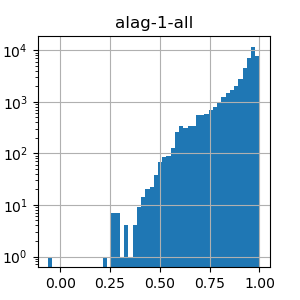

In [36]:
## EXPLORE 

cols = df_cleanup_1.columns 

sample_col_nr = np.random.randint(low=0, high = len(cols)-1)
col_name = cols[sample_col_nr]

plt.figure(figsize=(3,3))
plt.title(col_name)
df_cleanup_1[col_name].hist(bins=50)
plt.yscale('log')

In [26]:
# print('Load a high resolution DEM to find gauge values')
# print('\nFirst: check bias of DEM - compare available elevation values with data from gauges') 
# print('Try using eu-dem for this end. First create an index for all existing tiles')


# ## create indexing for eu-dem files 
# ## eu dem has spatial resolution of 25x25m and RSME of 7 
# ## this indicates high enough quality to fill data with 

# ## 1 - with 8 samples, RMSE = 17 
# ## 2- with 7 samples, RMSE = 11.774964125249552
# ## aster30m : RMSE:  35.965623978738364 with 50 samples 

# def eu_dem_index(dem_dir):

#     dem_files = [file for file in eu_dem_dir.glob('*.tif')]

#     ## set up tile identifiers 
#     tiles = [ file.stem.split('_')[-1] for file in dem_files]    
#     df_tiles = pd.DataFrame({'tile': tiles, 'fn': dem_files})
#     df_tiles['lon'] = [ int(string[1:3]) for string in tiles ]
#     df_tiles['lat'] = [ int(string[4:]) for string in tiles ]    
    
#     for i, file in enumerate(dem_files):
#         print('{}/{}'.format((i+1), len(dem_files)))
#         ds = gdal.Open(str(file))
#         dem_data = ds.GetRasterBand(1).ReadAsArray() 
#         rows, cols = dem_data.shape 

#         ## geotransormation [ x_top_left, d_x, rot_x, y_top_left, rot_y, d_y ]
#         GeoT = ds.GetGeoTransform() 
        
#         ## get coordinate boundaries 
#         x_min, y_max = GeoT[0], GeoT[3]
#         x_max, y_min = x_min + (GeoT[1]*cols), y_max + (GeoT[5]*rows)
        
#         df_tiles.loc[ df_tiles['fn'] == file, 'x_min' ] = x_min
#         df_tiles.loc[ df_tiles['fn'] == file, 'y_min' ] = y_min
#         df_tiles.loc[ df_tiles['fn'] == file, 'x_max' ] = x_max
#         df_tiles.loc[ df_tiles['fn'] == file, 'y_max' ] = y_max
        
#         ## close files 
#         dem_data = None
#         ds = None    
    
#     return df_tiles 

# ix_missing = df_gauge.loc[ df_gauge['elevation'].isnull() ].index 

# def search_val(search_X, search_Y, df_dem):
    
#     ## find matching tile for search_X and search_Y
#     x_filter = (df_dem['x_min'] <= search_X) & (df_dem['x_max'] >= search_X)
#     y_filter = (df_dem['y_min'] <= search_Y) & (df_dem['y_max'] >= search_Y)
    
#     tile = df_dem[ x_filter & y_filter] 

#     if len(tile) > 0:
#         ## tile is found 

#         ## find location index 
#         ix_rows = int( (tile['y_max'].values[0] - search_Y ) / 25.)
#         ix_cols = int( (search_X - tile['x_min'].values[0] ) / 25.) 
        
#         try:
#             ds = gdal.Open( str( tile['fn'].values[0] ) )
#             dem_data = ds.GetRasterBand(1).ReadAsArray()
#             dem_val = dem_data[ix_rows, ix_cols]
#             ds, dem_data = None, None
#         except:
#             dem_val = np.nan    

#     return dem_val 



# def test_and_fill_dem(df, df_dem, threshold=50., check_rmse = True): 
    
#     ## get values to check 
#     df_vals = df[['x', 'y', 'elevation']].copy() 
    
#     do_fill = True 
    
#     if check_rmse: 
#         ## first test error of DEM with gauge values 
#         df_check = df_vals.loc[ df_vals['elevation'].notna() ].sample(10).copy()

#         ## find values in dem 
#         for gauge_id in df_check.index:
#             search_X, search_Y = df_check.loc[gauge_id, ['x', 'y']].values 

#             dem_val = search_val(search_X, search_Y, df_dem)
#             print( df_check.loc[gauge_id, 'elevation'], dem_val )
#             df_check.loc[gauge_id, 'fill_dem'] = dem_val 
                
#         sum_not_found = df_check['fill_dem'].isnull().sum()
#         print('not found: ',sum_not_found)

#         if sum_not_found > int(0.5*len(df_check)):
#             print('Not enough values to compare - retry analysis')
#             return df 

#         ## drop nan values and continue RMSE calculation
#         df_check = df_check.dropna(subset=['fill_dem']).copy()

#         ## calculate RMSE 
#         df_check['abs_diff'] = ((df_check['fill_dem']-df_check['elevation'])**2) 

#         print('\nAbsolute differences between DEM and gauge data')
#         print(df_check['abs_diff'].describe()) 

#         rmse = (df_check['abs_diff'].sum()/len(df_check))**0.5
#         print('\nRMSE: ', rmse ) 
        
#         if rmse < threshold:
#             print('RMSE below threshold ({}) - use dem to fill missing data'.format(threshold))
#         else:
#             print('RMSE over threshold ({}) - find other dataset'.format(threshold))
    
#     if do_fill:
#         df_nan = df_vals.loc[ df_vals['elevation'].isnull()] 
        
#         for gauge_id in df_nan.index:
        
#             search_X, search_Y = df_nan.loc[gauge_id, ['x', 'y']].values 
            
#             dem_val = search_val(search_X, search_Y, df_dem)
#             print('Save')
#             print( df_check.loc[gauge_id, 'elevation'], dem_val )
#             df.loc[gauge_id, 'fill_dem'] = dem_val 

#     return df

# # eu_dem_dir = Path(r"F:\thesis_data\EU-DEM\eu_dem_v11")
# # df_eu_dem = eu_dem_index(eu_dem_dir) 

# print('Then test quality of DEM and fill in missing values if quality deemed good enough')

# # df_eu_dem

# ## then test quality of dem and 

# ## fill gauge file 
# # df_gauge = test_and_fill_dem(df_gauge, df_eu_dem)

# ## copy data to main dataframe - flag which values have been filled
# # df_signatures['fill_dem'] = 0
# # df_signatures.loc[ix_missing, 'elevation'] = df_gauge.loc[ix_missing, 'elevation'] 
# # df_signatures.loc[ix_missing, 'fill_dem'] = 1 

In [27]:
# ## merge all CSV signatures file into 1 csv file 
# csv_signature_dir = training_dir / "signatures_nc_V1_output" / "csv_signatures" 
# csv_files = [file for file in csv_signature_dir.glob('*.csv')] 

# df = pd.concat(map(pd.read_csv, csv_files)) 
# df = df.set_index('ID')

# out_fn = training_dir / "signatures_nc_V1_output" / "S1_merged_signatures.csv" 
# df.to_csv(out_fn)

In [28]:
# ## check n observations per gauge 
# obs_dir = training_dir / 'V1' 

# for gauge_id in df_gauge_meta.index:
    
#     gauge_fn = obs_dir / '{}_Q_Day.Cmd.txt'.format(gauge_id)
    
#     if gauge_fn.exists():
        
#         ## load obvservations 
#         df_data = pd.read_csv(gauge_fn, skiprows=36, delimiter=';', encoding = 'cp850')  
        
#         ## convert dates to datetime 
#         date_obs = pd.to_datetime(df_data['YYYY-MM-DD'], yearfirst=True, 
#                                   format='%Y-%m-%d') 
        
#         ## get observations in EFAs period (>=1991)
#         Q_obs = df_data.loc[date_obs >= '1991', ' Value'].copy()  
        
#         ## mark NaN values 
#         Q_obs[ Q_obs == -999.] = np.nan 
        
#         ## save n observations and close file 
#         df_gauge_meta.loc[gauge_id, 'n_obs_EFAS_period'] = len(Q_obs)
#         df_gauge_meta.loc[gauge_id, 'n_nan_EFAS_period'] = Q_obs.isnull().sum()
#         df_data = None 

# print( df_gauge_meta[['n_obs_EFAS_period','n_nan_EFAS_period']].describe() )

# fn = training_dir / "V1_grdc_efas_selection-cartesius-snapped-1.csv"
# df_gauge_meta.to_csv(fn)

In [29]:
## find missing gauge file 
# csv_signature_dir = training_dir / "signatures_nc_V1_output" / "csv_signatures"

# for gauge_ID in df_gauge_meta.index:
    
#     find_csv_file = csv_signature_dir / 'signatures_{}.csv'.format(gauge_ID)
    
#     if not find_csv_file.exists():
#         print(gauge_ID)